# Tutorial 2: Introduction to PyTorch Part2

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=green)

**Filled notebook:** 
[![View filled on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.ipynb)
[![Open filled In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.ipynb)   
**Recordings:** 
[![YouTube - Part 1](https://img.shields.io/static/v1.svg?logo=youtube&label=YouTube&message=Part%201&color=red)](https://youtu.be/wnKZZgFQY-E)
[![YouTube - Part 2](https://img.shields.io/static/v1.svg?logo=youtube&label=YouTube&message=Part%202&color=red)](https://youtu.be/schbjeU5X2g)

## Learning by example: Continuous XOR

If we want to build a neural network in PyTorch, we could specify all our parameters (weight matrices, bias vectors) using `Tensors` (with `requires_grad=True`), ask PyTorch to calculate the gradients and then adjust the parameters. But things can quickly get cumbersome if we have a lot of parameters. In PyTorch, there is a package called `torch.nn` that makes building neural networks more convenient. 

We will introduce the libraries and all additional parts you might need to train a neural network in PyTorch, using a simple example classifier on a simple yet well known example: XOR. Given two binary inputs $x_1$ and $x_2$, the label to predict is $1$ if either $x_1$ or $x_2$ is $1$ while the other is $0$, or the label is $0$ in all other cases. The example became famous by the fact that a single neuron, i.e. a linear classifier, cannot learn this simple function.
Hence, we will learn how to build a small neural network that can learn this function. 
To make it a little bit more interesting, we move the XOR into continuous space and introduce some gaussian noise on the binary inputs. Our desired separation of an XOR dataset could look as follows:

<center style="width: 100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial2/continuous_xor.svg?raw=1" width="350px"></center>

### The model

The package `torch.nn` defines a series of useful classes like linear networks layers, activation functions, loss functions etc. A full list can be found [here](https://pytorch.org/docs/stable/nn.html). In case you need a certain network layer, check the documentation of the package first before writing the layer yourself as the package likely contains the code for it already. We import it below:

In [1]:
import torch.nn as nn

Additionally to `torch.nn`, there is also `torch.nn.functional`. It contains functions that are used in network layers. This is in contrast to `torch.nn` which defines them as `nn.Modules` (more on it below), and `torch.nn` actually uses a lot of functionalities from `torch.nn.functional`. Hence, the functional package is useful in many situations, and so we import it as well here.

In [2]:
import torch.nn.functional as F

#### nn.Module

In PyTorch, a neural network is built up out of modules. Modules can contain other modules, and a neural network is considered to be a module itself as well. The basic template of a module is as follows:

In [3]:
class MyModule(nn.Module):
    
    def __init__(self):
        super().__init__()
        # Some init for my module
        
    def forward(self, x):
        # Function for performing the calculation of the module.
        pass

The forward function is where the computation of the module is taken place, and is executed when you call the module (`nn = MyModule(); nn(x)`). In the init function, we usually create the parameters of the module, using `nn.Parameter`, or defining other modules that are used in the forward function. The backward calculation is done automatically, but could be overwritten as well if wanted.

#### Simple classifier
We can now make use of the pre-defined modules in the `torch.nn` package, and define our own small neural network. We will use a minimal network with a input layer, one hidden layer with tanh as activation function, and a output layer. In other words, our networks should look something like this:

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial2/small_neural_network.svg?raw=1" width="300px"></center>

The input neurons are shown in blue, which represent the coordinates $x_1$ and $x_2$ of a data point. The hidden neurons including a tanh activation are shown in white, and the output neuron in red.
In PyTorch, we can define this as follows:

In [4]:
class SimpleClassifier(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        # Initialize the modules we need to build the network
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x

For the examples in this notebook, we will use a tiny neural network with two input neurons and four hidden neurons. As we perform binary classification, we will use a single output neuron. Note that we do not apply a sigmoid on the output yet. This is because other functions, especially the loss, are more efficient and precise to calculate on the original outputs instead of the sigmoid output. We will discuss the detailed reason later.

In [5]:
model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
# Printing a module shows all its submodules
print(model)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)


Printing the model lists all submodules it contains. The parameters of a module can be obtained by using its `parameters()` functions, or `named_parameters()` to get a name to each parameter object. For our small neural network, we have the following parameters:

In [6]:
for name, param in model.named_parameters():
    print(f"Parameter {name}, shape {param.shape}")

Parameter linear1.weight, shape torch.Size([4, 2])
Parameter linear1.bias, shape torch.Size([4])
Parameter linear2.weight, shape torch.Size([1, 4])
Parameter linear2.bias, shape torch.Size([1])


Each linear layer has a weight matrix of the shape `[output, input]`, and a bias of the shape `[output]`. The tanh activation function does not have any parameters. Note that parameters are only registered for `nn.Module` objects that are direct object attributes, i.e. `self.a = ...`. If you define a list of modules, the parameters of those are not registered for the outer module and can cause some issues when you try to optimize your module. There are alternatives, like `nn.ModuleList`, `nn.ModuleDict` and `nn.Sequential`, that allow you to have different data structures of modules. We will use them in a few later tutorials and explain them there. 

### The data

PyTorch also provides a few functionalities to load the training and test data efficiently, summarized in the package `torch.utils.data`.

In [7]:
import torch.utils.data as data

The data package defines two classes which are the standard interface for handling data in PyTorch: `data.Dataset`, and `data.DataLoader`. The dataset class provides an uniform interface to access the training/test data, while the data loader makes sure to efficiently load and stack the data points from the dataset into batches during training.

#### The dataset class

The dataset class summarizes the basic functionality of a dataset in a natural way. To define a dataset in PyTorch, we simply specify two functions: `__getitem__`, and `__len__`. The get-item function has to return the $i$-th data point in the dataset, while the len function returns the size of the dataset. For the XOR dataset, we can define the dataset class as follows:

In [8]:
import torch


class XORDataset(data.Dataset):

    def __init__(self, size, std=0.1):
        """
        Inputs:
            size - Number of data points we want to generate
            std - Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        self.size = size
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        # Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
        # The label is their XOR combination, i.e. 1 if only x or only y is 1 while the other is 0.
        # If x=y, the label is 0.
        data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        label = (data.sum(dim=1) == 1).to(torch.long)
        # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
        data += self.std * torch.randn(data.shape)

        self.data = data
        self.label = label

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

Let's try to create such a dataset and inspect it:

In [9]:
dataset = XORDataset(size=200)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])

Size of dataset: 200
Data point 0: (tensor([ 0.0377, -0.1323]), tensor(0))


To better relate to the dataset, we visualize the samples below. 

In [10]:
from matplotlib import pyplot as plt


def visualize_samples(data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]
    
    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

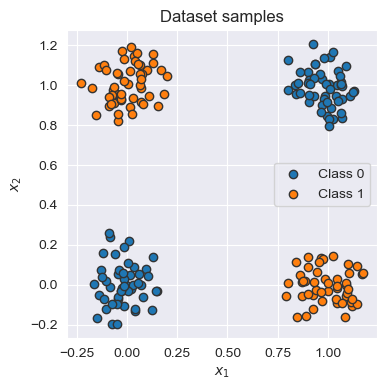

In [11]:
visualize_samples(dataset.data, dataset.label)
plt.show()

#### The data loader class

The class `torch.utils.data.DataLoader` represents a Python iterable over a dataset with support for automatic batching, multi-process data loading and many more features. The data loader communicates with the dataset using the function `__getitem__`, and stacks its outputs as tensors over the first dimension to form a batch.
In contrast to the dataset class, we usually don't have to define our own data loader class, but can just create an object of it with the dataset as input. Additionally, we can configure our data loader with the following input arguments (only a selection, see full list [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)):

* `batch_size`: Number of samples to stack per batch
* `shuffle`: If True, the data is returned in a random order. This is important during training for introducing stochasticity. 
* `num_workers`: Number of subprocesses to use for data loading. The default, 0, means that the data will be loaded in the main process which can slow down training for datasets where loading a data point takes a considerable amount of time (e.g. large images). More workers are recommended for those, but can cause issues on Windows computers. For tiny datasets as ours, 0 workers are usually faster.
* `pin_memory`: If True, the data loader will copy Tensors into CUDA pinned memory before returning them. This can save some time for large data points on GPUs. Usually a good practice to use for a training set, but not necessarily for validation and test to save memory on the GPU.
* `drop_last`: If True, the last batch is dropped in case it is smaller than the specified batch size. This occurs when the dataset size is not a multiple of the batch size. Only potentially helpful during training to keep a consistent batch size.

Let's create a simple data loader below:

In [12]:
data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True,pin_memory=True)

In [13]:
# next(iter(...)) catches the first batch of the data loader
# If shuffle is True, this will return a different batch every time we run this cell
# For iterating over the whole dataset, we can simple use "for batch in data_loader: ..."
data_inputs, data_labels = next(iter(data_loader))

# The shape of the outputs are [batch_size, d_1,...,d_N] where d_1,...,d_N are the 
# dimensions of the data point returned from the dataset class
print("Data inputs", data_inputs.shape, "\n", data_inputs)
print("Data labels", data_labels.shape, "\n", data_labels)

Data inputs torch.Size([8, 2]) 
 tensor([[ 1.0685,  1.0009],
        [ 0.1526,  0.8969],
        [ 0.1703,  1.0748],
        [-0.0152,  1.0180],
        [ 0.9842,  0.9446],
        [ 0.0230,  0.8570],
        [-0.0238, -0.0165],
        [ 1.1006, -0.0227]])
Data labels torch.Size([8]) 
 tensor([0, 1, 1, 1, 0, 1, 0, 1])


### Optimization

After defining the model and the dataset, it is time to prepare the optimization of the model. During training, we will perform the following steps:

1. Get a batch from the data loader
2. Obtain the predictions from the model for the batch
3. Calculate the loss based on the difference between predictions and labels
4. Backpropagation: calculate the gradients for every parameter with respect to the loss
5. Update the parameters of the model in the direction of the gradients

We have seen how we can do step 1, 2 and 4 in PyTorch. Now, we will look at step 3 and 5.

#### Loss modules

We can calculate the loss for a batch by simply performing a few tensor operations as those are automatically added to the computation graph. For instance, for binary classification, we can use Binary Cross Entropy (BCE) which is defined as follows:

$$\mathcal{L}_{BCE} = -\sum_i \left[ y_i \log x_i + (1 - y_i) \log (1 - x_i) \right]$$

where $y$ are our labels, and $x$ our predictions, both in the range of $[0,1]$. However, PyTorch already provides a list of predefined loss functions which we can use (see [here](https://pytorch.org/docs/stable/nn.html#loss-functions) for a full list). For instance, for BCE, PyTorch has two modules: `nn.BCELoss()`, `nn.BCEWithLogitsLoss()`. While `nn.BCELoss` expects the inputs $x$ to be in the range $[0,1]$, i.e. the output of a sigmoid, `nn.BCEWithLogitsLoss` combines a sigmoid layer and the BCE loss in a single class. This version is numerically more stable than using a plain Sigmoid followed by a BCE loss because of the logarithms applied in the loss function. Hence, it is adviced to use loss functions applied on "logits" where possible (remember to not apply a sigmoid on the output of the model in this case!). For our model defined above, we therefore use the module `nn.BCEWithLogitsLoss`. 

In [14]:
loss_module = nn.BCEWithLogitsLoss()

#### Stochastic Gradient Descent

For updating the parameters, PyTorch provides the package `torch.optim` that has most popular optimizers implemented. We will discuss the specific optimizers and their differences later in the course, but will for now use the simplest of them: `torch.optim.SGD`. Stochastic Gradient Descent updates parameters by multiplying the gradients with a small constant, called learning rate, and subtracting those from the parameters (hence minimizing the loss). Therefore, we slowly move towards the direction of minimizing the loss. A good default value of the learning rate for a small network as ours is 0.1. 

In [15]:
# Input to the optimizer are the parameters of the model: model.parameters()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

The optimizer provides two useful functions: `optimizer.step()`, and `optimizer.zero_grad()`. The step function updates the parameters based on the gradients as explained above. The function `optimizer.zero_grad()` sets the gradients of all parameters to zero. While this function seems less relevant at first, it is a crucial pre-step before performing backpropagation. If we would call the `backward` function on the loss while the parameter gradients are non-zero from the previous batch, the new gradients would actually be added to the previous ones instead of overwriting them. This is done because a parameter might occur multiple times in a computation graph, and we need to sum the gradients in this case instead of replacing them. Hence, remember to call `optimizer.zero_grad()` before calculating the gradients of a batch.

### Training

Finally, we are ready to train our model. As a first step, we create a slightly larger dataset and specify a data loader with a larger batch size. 

In [16]:
train_dataset = XORDataset(size=2500)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True,pin_memory=True)

Now, we can write a small training function. Remember our five steps: load a batch, obtain the predictions, calculate the loss, backpropagate, and update. Additionally, we have to push all data and model parameters to the device of our choice (GPU if available). For the tiny neural network we have, communicating the data to the GPU actually takes much more time than we could save from running the operation on GPU. For large networks, the communication time is significantly smaller than the actual runtime making a GPU crucial in these cases. Still, to practice, we will push the data to GPU here. 

In [17]:
# Push model to device. Has to be only done once
device = "cuda"
model.to(device)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)

In addition, we set our model to training mode. This is done by calling `model.train()`. There exist certain modules that need to perform a different forward step during training than during testing (e.g. BatchNorm and Dropout), and we can switch between them using `model.train()` and `model.eval()`.

In [18]:
from tqdm import tqdm


def train_model(model, optimizer, data_loader, loss_module, num_epochs=100):
    # Set model to train mode
    model.train() 
    
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        for data_inputs, data_labels in data_loader:
            
            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)
            
            ## Step 2: Run the model on the input data
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]
            
            ## Step 3: Calculate the loss
            loss = loss_module(preds, data_labels.float())
            
            ## Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero. 
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad() 
            # Perform backpropagation
            loss.backward()
            
            ## Step 5: Update the parameters
            optimizer.step()

In [19]:
train_model(model, optimizer, train_data_loader, loss_module)

100%|██████████| 100/100 [00:02<00:00, 35.16it/s]


#### Saving a model

After finish training a model, we save the model to disk so that we can load the same weights at a later time. For this, we extract the so-called `state_dict` from the model which contains all learnable parameters. For our simple model, the state dict contains the following entries:

In [20]:
state_dict = model.state_dict()
print(state_dict)

OrderedDict([('linear1.weight', tensor([[-2.9564,  1.2639],
        [-0.0105, -0.0101],
        [ 2.8200, -3.4202],
        [ 2.4062,  2.6723]], device='cuda:0')), ('linear1.bias', tensor([ 0.0246,  0.7350, -1.3152, -0.7126], device='cuda:0')), ('linear2.weight', tensor([[4.0068, 0.1362, 4.2645, 3.7417]], device='cuda:0')), ('linear2.bias', tensor([0.6148], device='cuda:0'))])


To save the state dictionary, we can use `torch.save`:

In [21]:
# torch.save(object, filename). For the filename, any extension can be used
torch.save(state_dict, "our_model.tar")

To load a model from a state dict, we use the function `torch.load` to load the state dict from the disk, and the module function `load_state_dict` to overwrite our parameters with the new values:

In [22]:
# Load state dict from the disk (make sure it is the same name as above)
state_dict = torch.load("our_model.tar")

# Create a new model and load the state
new_model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
new_model.load_state_dict(state_dict)

# Verify that the parameters are the same
print("Original model\n", model.state_dict())
print("\nLoaded model\n", new_model.state_dict())

Original model
 OrderedDict([('linear1.weight', tensor([[-2.9564,  1.2639],
        [-0.0105, -0.0101],
        [ 2.8200, -3.4202],
        [ 2.4062,  2.6723]], device='cuda:0')), ('linear1.bias', tensor([ 0.0246,  0.7350, -1.3152, -0.7126], device='cuda:0')), ('linear2.weight', tensor([[4.0068, 0.1362, 4.2645, 3.7417]], device='cuda:0')), ('linear2.bias', tensor([0.6148], device='cuda:0'))])

Loaded model
 OrderedDict([('linear1.weight', tensor([[-2.9564,  1.2639],
        [-0.0105, -0.0101],
        [ 2.8200, -3.4202],
        [ 2.4062,  2.6723]])), ('linear1.bias', tensor([ 0.0246,  0.7350, -1.3152, -0.7126])), ('linear2.weight', tensor([[4.0068, 0.1362, 4.2645, 3.7417]])), ('linear2.bias', tensor([0.6148]))])


A detailed tutorial on saving and loading models in PyTorch can be found [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

### Evaluation

Once we have trained a model, it is time to evaluate it on a held-out test set. As our dataset consist of randomly generated data points, we need to first create a test set with a corresponding data loader.

In [23]:
test_dataset = XORDataset(size=500)
# drop_last -> Don't drop the last batch although it is smaller than 128
test_data_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False) 

As metric, we will use accuracy which is calculated as follows:

$$acc = \frac{\#\text{correct predictions}}{\#\text{all predictions}} = \frac{TP+TN}{TP+TN+FP+FN}$$

where TP are the true positives, TN true negatives, FP false positives, and FN the fale negatives. 

When evaluating the model, we don't need to keep track of the computation graph as we don't intend to calculate the gradients. This reduces the required memory and speed up the model. In PyTorch, we can deactivate the computation graph using `with torch.no_grad(): ...`. Remember to additionally set the model to eval mode.

In [24]:
def eval_model(model, data_loader):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.
    
    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:
            
            # Determine prediction of model on dev set
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds) # Sigmoid to map predictions between 0 and 1
            pred_labels = (preds >= 0.5).long() # Binarize predictions to 0 and 1
            
            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]
            
    acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

In [25]:
eval_model(model, test_data_loader)

Accuracy of the model: 100.00%


If we trained our model correctly, we should see a score close to 100% accuracy. However, this is only possible because of our simple task, and unfortunately, we usually don't get such high scores on test sets of more complex tasks.

#### Visualizing classification boundaries

To visualize what our model has learned, we can perform a prediction for every data point in a range of $[-0.5, 1.5]$, and visualize the predicted class as in the sample figure at the beginning of this section. This shows where the model has created decision boundaries, and which points would be classified as $0$, and which as $1$. We therefore get a background image out of blue (class 0) and orange (class 1). The spots where the model is uncertain we will see a blurry overlap. The specific code is less relevant compared to the output figure which should hopefully show us a clear separation of classes:

C:\ProgramData\anaconda3\envs\ML\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


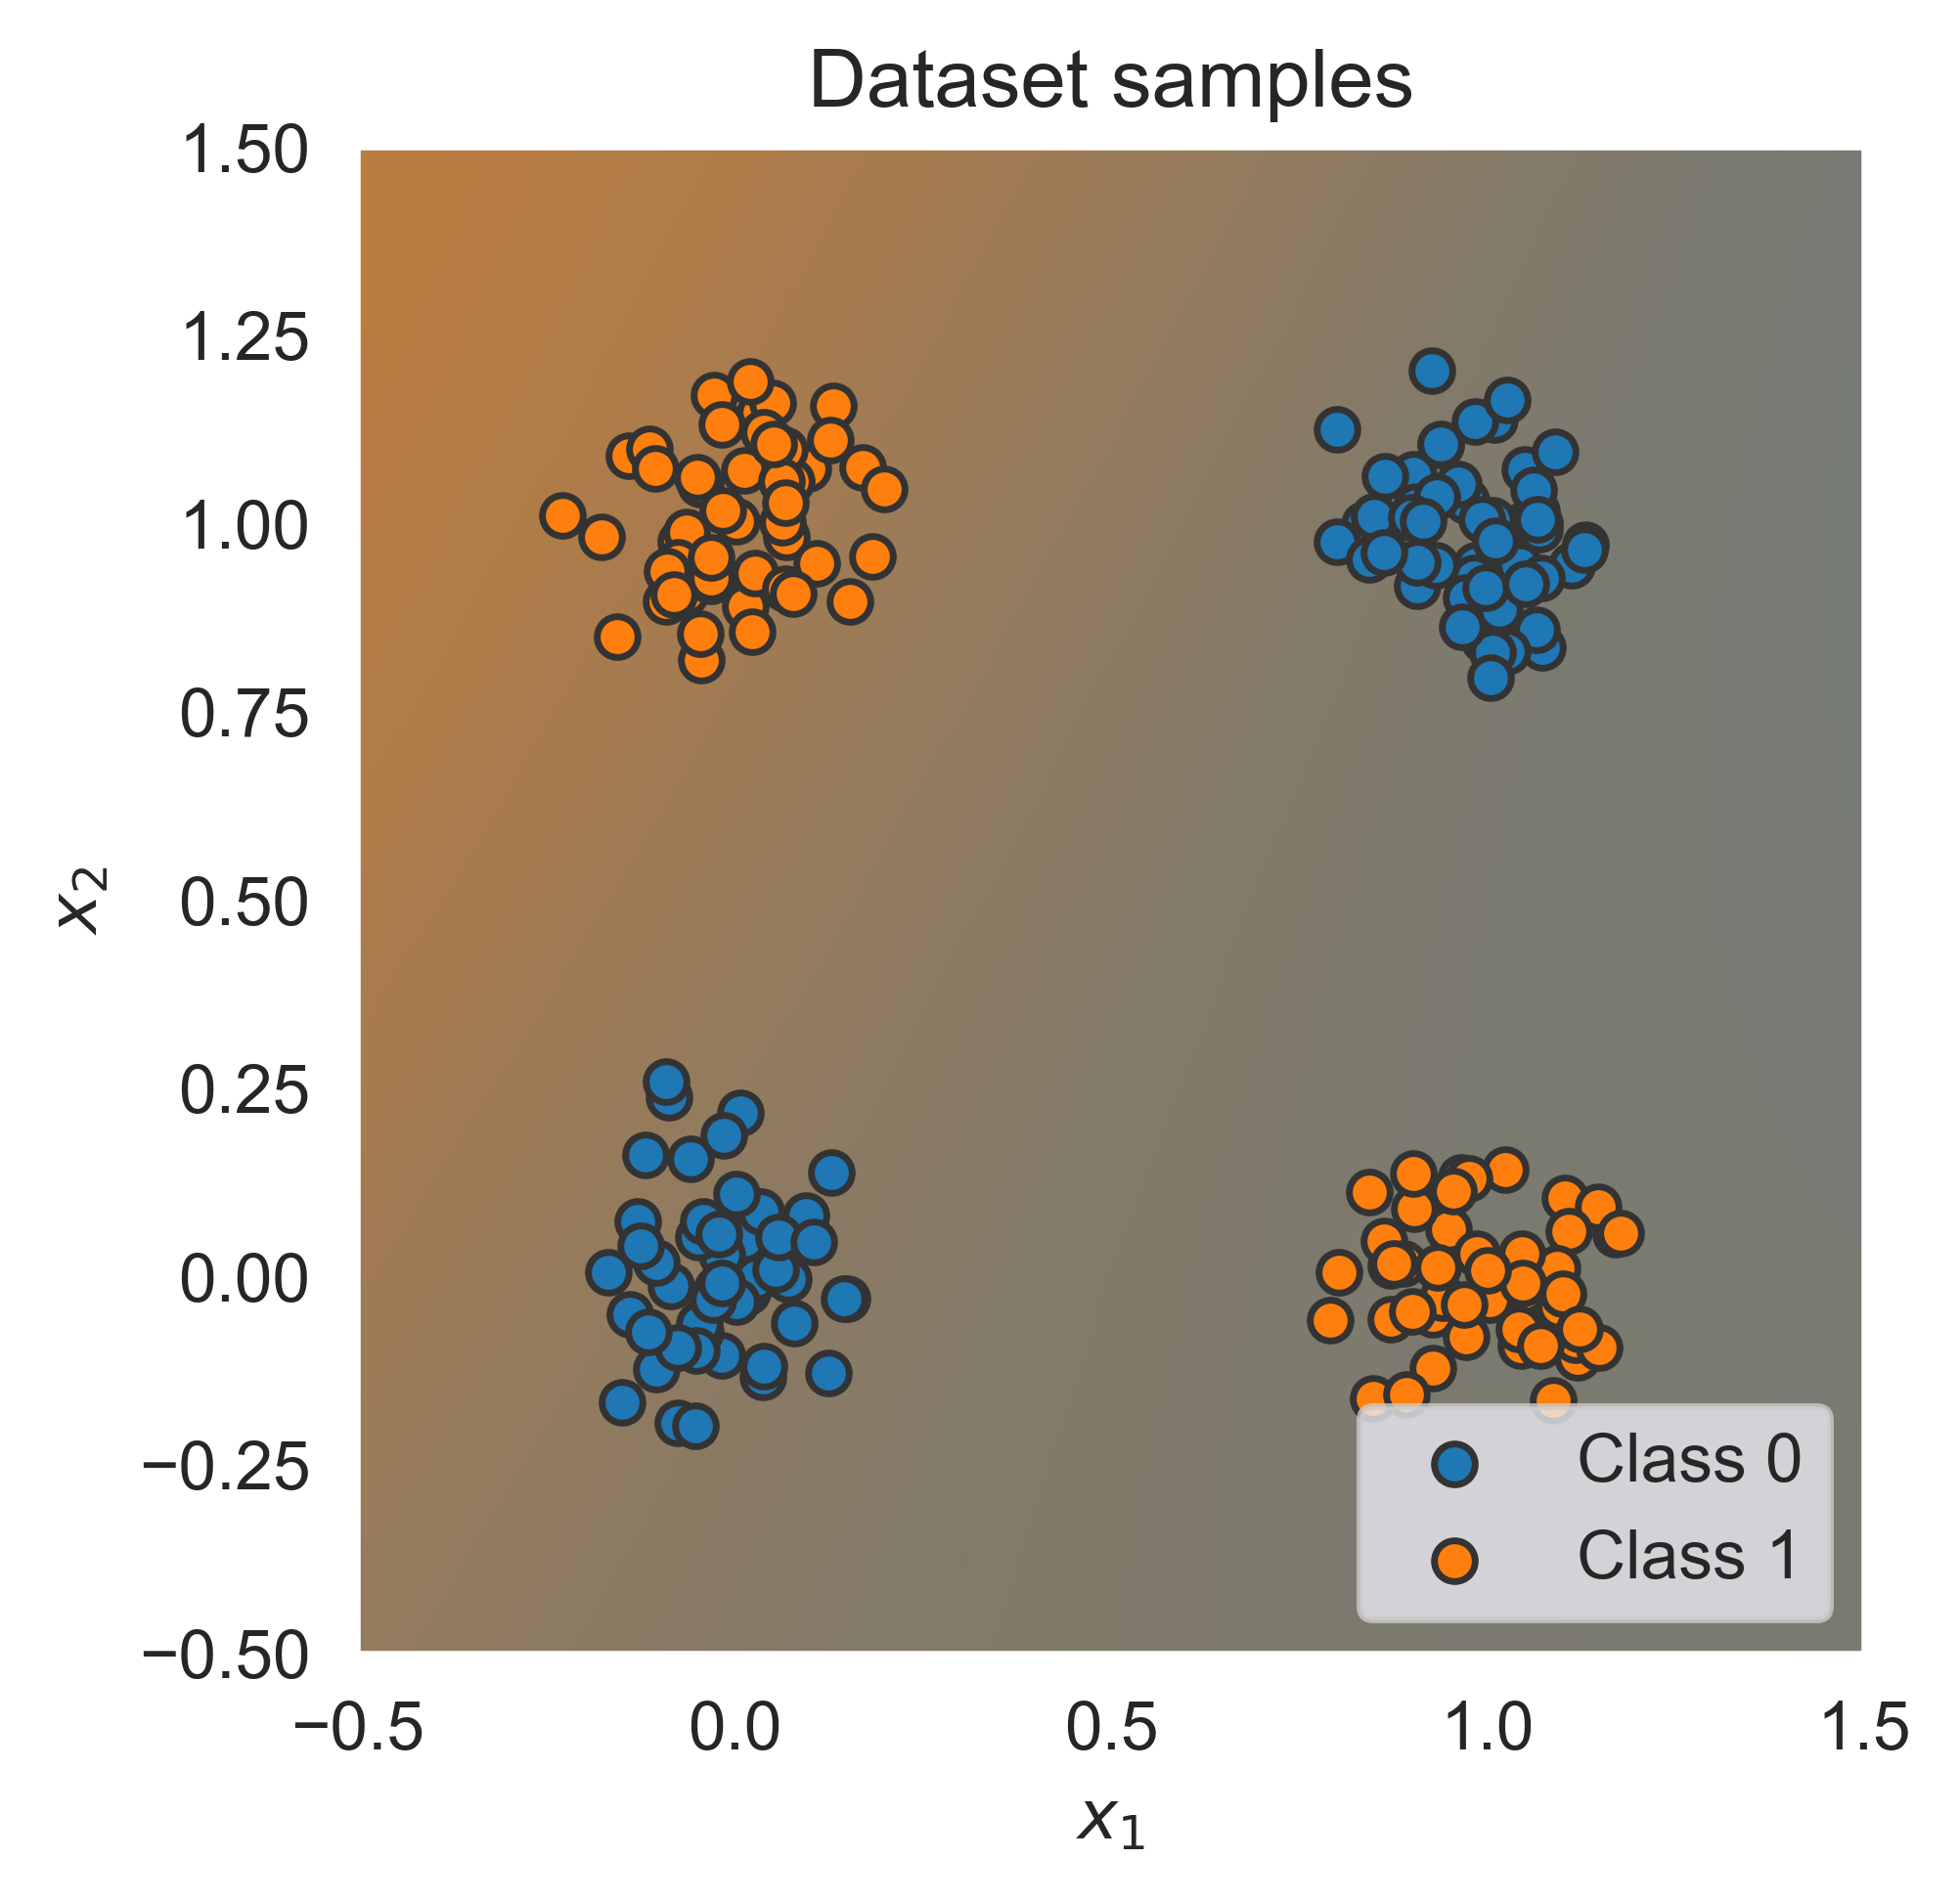

In [40]:
from matplotlib.colors import to_rgba


@torch.no_grad() # Decorator, same effect as "with torch.no_grad(): ..." over the whole function.
def visualize_classification(model, data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]
    
    fig = plt.figure(figsize=(4,4), dpi=500)
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()
    
    # Let's make use of a lot of operations we have learned above
    model.to(device)
    c0 = torch.Tensor(to_rgba("C0")).to(device)
    c1 = torch.Tensor(to_rgba("C1")).to(device)
    x1 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    x2 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2)  # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    preds = model(model_inputs)
    preds = torch.sigmoid(preds)
    output_image = (1 - preds) * c0[None,None] + preds * c1[None,None]  # Specifying "None" in a dimension creates a new one
    output_image = output_image.cpu().numpy()  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin='lower', extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)
    return fig

_ = visualize_classification(model, dataset.data, dataset.label)
plt.show()

The decision boundaries might not look exactly as in the figure in the preamble of this section which can be caused by running it on CPU or a different GPU architecture. Nevertheless, the result on the accuracy metric should be the approximately the same. 

## Additional features we didn't get to discuss yet

Finally, you are all set to start with your own PyTorch project! In summary, we have looked at how we can build neural networks in PyTorch, and train and test them on data. However, there is still much more to PyTorch we haven't discussed yet. In the comming series of Jupyter notebooks, we will discover more and more functionalities of PyTorch, so that you also get familiar to PyTorch concepts beyond the basics. If you are already interested in learning more of PyTorch, we recommend the official [tutorial website](https://pytorch.org/tutorials/) that contains many tutorials on various topics. Especially logging with Tensorboard ([official tutorial here](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html)) is a good practice that we will explore further from Tutorial 5 on in combination with PyTorch Lightning.
Nonetheless, let's check it shortly out how we could use TensorBoard in our small example.

### TensorBoard logging

TensorBoard is a logging and visualization tool that is a popular choice for training deep learning models. Although initially published for TensorFlow, TensorBoard is also integrated in PyTorch allowing us to easily use it. First, let's import it below.

In [45]:
# Import tensorboard logger from PyTorch
from torch.utils.tensorboard import SummaryWriter

# Load tensorboard extension for Jupyter Notebook, only need to start TB in the notebook
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


The last line is required if you want to run TensorBoard directly in the Jupyter Notebook. Otherwise, you can start TensorBoard from the terminal.

PyTorch's TensorBoard API is simple to use. We start the logging process by creating a new object, `writer = SummaryWriter(...)`, where we specify the directory in which the logging file should be saved. With this object, we can log different aspects of our model by calling functions of the style `writer.add_...`. For example, we can visualize the computation graph with the function `writer.add_graph`, or add a scalar value like the loss with `writer.add_scalar`. Let's adapt our initial training function with adding a TensorBoard logger below.

In [42]:
def train_model_with_logger(model, optimizer, data_loader, loss_module, val_dataset, num_epochs=100, logging_dir='runs/our_experiment'):
    # Create TensorBoard logger
    writer = SummaryWriter(logging_dir)
    model_plotted = False
    
    # Set model to train mode
    model.train() 
    
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        epoch_loss = 0.0
        for data_inputs, data_labels in data_loader:
            
            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)
            
            # For the very first batch, we visualize the computation graph in TensorBoard
            if not model_plotted:
                writer.add_graph(model, data_inputs)
                model_plotted = True
            
            ## Step 2: Run the model on the input data
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]
            
            ## Step 3: Calculate the loss
            loss = loss_module(preds, data_labels.float())
            
            ## Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero. 
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad() 
            # Perform backpropagation
            loss.backward()
            
            ## Step 5: Update the parameters
            optimizer.step()
            
            ## Step 6: Take the running average of the loss
            epoch_loss += loss.item()
            
        # Add average loss to TensorBoard
        epoch_loss /= len(data_loader)
        writer.add_scalar('training_loss',
                          epoch_loss,
                          global_step = epoch + 1)
        
        # Visualize prediction and add figure to TensorBoard
        # Since matplotlib figures can be slow in rendering, we only do it every 10th epoch
        if (epoch + 1) % 10 == 0:
            fig = visualize_classification(model, val_dataset.data, val_dataset.label)
            writer.add_figure('predictions',
                              fig,
                              global_step = epoch + 1)
    
    writer.close()

Let's use this method to train a model as before, with a new model and optimizer.

In [43]:
model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1).to("cuda")
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
train_model_with_logger(model, optimizer, train_data_loader, loss_module, val_dataset=dataset)

100%|██████████| 100/100 [00:05<00:00, 19.64it/s]


The TensorBoard file in the folder `runs/our_experiment` now contains a loss curve, the computation graph of our network, and a visualization of the learned predictions over number of epochs. To start the TensorBoard visualizer, simply run the following statement:

In [44]:
%tensorboard --logdir runs/our_experiment

Launching TensorBoard...

<center><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial2/tensorboard_screenshot.png?raw=1" width="1100px"></center>

TensorBoard visualizations can help to identify possible issues with your model, and identify situations such as overfitting. You can also track the training progress while a model is training, since the logger automatically writes everything added to it to the logging file. Feel free to explore the TensorBoard functionalities, and we will make use of TensorBoards a couple of times from Tutorial 5 on.

### Self Practice (optional)
1.Try to use different optimizers to train the network, and compare the final performances.